<a href="https://colab.research.google.com/github/bobby-he/Neural_Tangent_Kernel/blob/master/notebooks/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/bobby-he/Neural_Tangent_Kernel.git

Cloning into 'Neural_Tangent_Kernel'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 175 (delta 72), reused 35 (delta 10), pack-reused 0
Receiving objects: 100% (175/175), 21.45 MiB | 9.72 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [0]:
from Neural_Tangent_Kernel.src.NTK_net import LinearNeuralTangentKernel, FourLayersNet, train_net, circle_transform, variance_est, cpu_tuple,\
                                              AnimationPlot_lsq, kernel_leastsq_update, kernel_mats

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

matplotlib_is_available = True
try:
  from matplotlib import pyplot as plt
except ImportError:
  print("Will skip plotting; matplotlib is not available.")
  matplotlib_is_available = False

# Data params
data_mean =-4
data_stddev = 1.25

# ### Uncomment only one of these to define what data is actually sent to the Discriminator
(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)


In [4]:
print("Using data [%s]" % (name))

# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = LinearNeuralTangentKernel(input_size, hidden_size, w_sig = 1)
        self.map2 = LinearNeuralTangentKernel(hidden_size, hidden_size, w_sig = np.sqrt(5))
        self.map3 = LinearNeuralTangentKernel(hidden_size, output_size, w_sig = np.sqrt(5))
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = LinearNeuralTangentKernel(input_size, hidden_size, w_sig = 1)
        self.map2 = LinearNeuralTangentKernel(hidden_size, hidden_size, w_sig = np.sqrt(10))
        self.map3 = LinearNeuralTangentKernel(hidden_size, output_size, w_sig = np.sqrt(10))
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)


Using data [Raw data]


In [0]:
def trainlol():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 500     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 500    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 0.001
    g_learning_rate = 0.001
    sgd_momentum = 0.9

    num_epochs = 1000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function).cuda()
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function).cuda()
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size)).cuda()
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])).cuda())  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size)).cuda()
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])).cuda())  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size)).cuda()
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])).cuda())  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: Fake Dist (%s),  D (%s real_err, %s fake_err) G (%s err); Real Dist (%s)" %
                  (epoch, stats(extract(d_fake_data)), dre, dfe, ge, stats(extract(d_real_data))))
    gen_input = Variable(gi_sampler(5000,1)).cuda()
    g_fake_data = G(gen_input)
    
    if matplotlib_is_available:
        print("Plotting the generated distribution...")
        values = extract(g_fake_data)
        #print(" Values: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()


Epoch 0: Fake Dist ([0.13215144761279227, 0.1643446142316272]),  D (0.17419731616973877 real_err, 1.3144066333770752 fake_err) G (0.3074413537979126 err); Real Dist ([-4.091358107045293, 1.276152474562594])
Epoch 100: Fake Dist ([-5.46443574821949, 1.8127410499230172]),  D (0.7270120978355408 real_err, 0.7386178970336914 fake_err) G (0.7571592330932617 err); Real Dist ([-4.002776446044445, 1.252882305561767])
Epoch 200: Fake Dist ([-5.185678830623627, 1.6310050248987775]),  D (0.5554349422454834 real_err, 0.5511603951454163 fake_err) G (0.5508284568786621 err); Real Dist ([-3.878346392631531, 1.2866388900190262])
Epoch 300: Fake Dist ([-3.1012582050561903, 1.1248947228986896]),  D (0.6099191308021545 real_err, 0.8353227376937866 fake_err) G (0.5626645088195801 err); Real Dist ([-3.9747554880976677, 1.2495902525299798])
Epoch 400: Fake Dist ([-4.348512374520302, 1.2907401055978136]),  D (0.6524342894554138 real_err, 0.6922794580459595 fake_err) G (0.5997262001037598 err); Real Dist ([-4

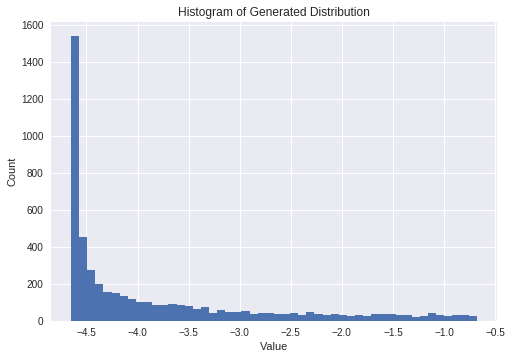

CPU times: user 2min 36s, sys: 10.5 s, total: 2min 47s
Wall time: 2min 48s


In [12]:
%%time
trainlol()